In [ ]:



MORFFY_DIR = '../../02-OUTPUT/26-evaluate_dataset_morffy/01-dataset'
TADA_DIR = '../../02-OUTPUT/29-compare_model_TADA'
INITIAL_GENERALIZABILITY_DIR = '../../02-OUTPUT/08-evaluate_initial_generalizability'
HARMONIZE_DIR = '../../02-OUTPUT/13-harmonize_datasets'
EMBEDDING_DIR = '../../02-OUTPUT/03-evaluate_embeddings'
GENERALIZABILITY_DIR = '../../02-OUTPUT/16-evaluate_updated_generalizability'

NOTEBOOK_ID = '24'

RUN_ORIGINAL_MODEL = False
RUN_40AA_MODEL = False
RUN_40AA_DEDUP_MODEL = False
RUN_HARMONIZED_MODEL = False
RUN_HUMMEL_MODEL = False
RUN_HUMMEL_COMPARISON = False
RUN_MORFFY_COMPARISON = False
RUN_GENERALIZABILITY = False

2025-04-08 15:01:44.722738: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-08 15:01:44.809548: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-08 15:01:45.186579: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2025-04-08 15:01:45.186626: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

# train/test TADA on Morffy

In [ ]:
if RUN_ORIGINAL_MODEL:
    with open(f'{MORFFY_DIR}/TrainingsData.csv', 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        data = []
        for i in csv_reader:
            data.append([i[0], i[1], i[2], i[3], i[4]])
    data.pop(0)

    sequences = [i[2] for i in data]
    data = np.array(data)
    y0 = np.double(data[:, 4])
    y = np.column_stack([y0, 1 - y0])

    if not os.path.isfile(f'{MORFFY_DIR}/features_OnlyPlants.pkl'):
        features = create_features(sequences, SEQUENCE_WINDOW, STEPS, LENGTH=40)
        dump(features, open(f'{MORFFY_DIR}/features_OnlyPlants.pkl', 'wb'))
    else:
        features = pd.read_pickle(f'{MORFFY_DIR}/features_OnlyPlants.pkl')

    X_train, X_test, y_train, y_test = train_test_split(features, y, random_state = 42, test_size=0.1, stratify = y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = 42, test_size=0.22, stratify = y_train)

    X_train_scaled = scale_features(X_train)
    X_test_scaled = scale_features(X_test)
    X_val_scaled = scale_features(X_val)

    dataset = (X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)
    train_TADA(dataset, TADA_DIR, out_name = 'morffy')
    test_TADA(dataset, TADA_DIR, out_name = 'morffy')

if RUN_40AA_MODEL:
    dataset_df = pd.read_csv(f'{MORFFY_DIR}/TrainingsData.csv')
    dataset_df = dataset_df[dataset_df['Sequence'].apply(lambda x: len(x) == 40)]
    data = dataset_df.to_numpy()

    sequences = [i[2] for i in data]
    data = np.array(data)
    y0 = np.double(data[:, 4])
    y = np.column_stack([y0, 1 - y0])

    features = pd.read_pickle(f'{MORFFY_DIR}/features_OnlyPlants.pkl')
    features = features[list(dataset_df.index),:,:]

    X_train, X_test, y_train, y_test = train_test_split(features, y, random_state = 42, test_size=0.1, stratify = y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = 42, test_size=0.22, stratify = y_train)

    X_train_scaled = scale_features(X_train)
    X_test_scaled = scale_features(X_test)
    X_val_scaled = scale_features(X_val)

    dataset = (X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)
    train_TADA(dataset, TADA_DIR, out_name = 'morffy_40aa')
    test_TADA(dataset, TADA_DIR, out_name = 'morffy_40aa')


if RUN_40AA_DEDUP_MODEL:
    dataset_df = pd.read_csv(f'{MORFFY_DIR}/TrainingsData.csv')
    dataset_df = dataset_df[dataset_df['Sequence'].apply(lambda x: len(x) == 40)].drop_duplicates(subset='Sequence')
    data = dataset_df.to_numpy()

    sequences = [i[2] for i in data]
    data = np.array(data)
    y0 = np.double(data[:, 4])
    y = np.column_stack([y0, 1 - y0])

    features = pd.read_pickle(f'{MORFFY_DIR}/features_OnlyPlants.pkl')
    features = features[list(dataset_df.index),:,:]

    X_train, X_test, y_train, y_test = train_test_split(features, y, random_state = 42, test_size=0.1, stratify = y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = 42, test_size=0.22, stratify = y_train)

    X_train_scaled = scale_features(X_train)
    X_test_scaled = scale_features(X_test)
    X_val_scaled = scale_features(X_val)

    dataset = (X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)
    train_TADA(dataset, TADA_DIR, out_name = 'morffy_40aa_dedup')
    test_TADA(dataset, TADA_DIR, out_name = 'morffy_40aa_dedup')

if RUN_HARMONIZED_MODEL:
    harmonized_df = pd.read_pickle(f'../../02-OUTPUT/11-harmonize_datasets/04-results/esm2_t33_650M_UR50D-layer33-representations.pkl').drop_duplicates(subset='AAseq')
    sequences = harmonized_df['AAseq'].to_list()
    y0 = np.double(harmonized_df['linear_harmonized_activity_scaled'].to_numpy())
    y0_bin = (y0 > y0.mean() + y0.std()).astype(np.int64)
    y = np.column_stack([y0_bin, 1 - y0_bin])

    if not os.path.isfile(f'{TADA_DIR}/harmonized_features.npy'):
        features = create_features(sequences, LENGTH=53)
        np.save(f'{TADA_DIR}/harmonized_features.npy',features)
    else:
        features = np.load(f'{TADA_DIR}/harmonized_features.npy')

    X_train, X_test, y_train, y_test = train_test_split(features, y, random_state = 42, test_size=0.1, stratify = y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = 42, test_size=0.22, stratify = y_train)

    X_train_scaled = scale_features(X_train,LENGTH=53)
    X_test_scaled = scale_features(X_test,LENGTH=53)
    X_val_scaled = scale_features(X_val,LENGTH=53)

    dataset = (X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)
    train_TADA(dataset, TADA_DIR, out_name='harmonized')
    test_TADA(dataset, TADA_DIR, out_name='harmonized')

# train/test TADA on Hummel

In [ ]:
if RUN_HUMMEL_MODEL:
    onehot_df = pd.read_pickle(f'../../02-OUTPUT/03-test_representations/01-encodings/hummel_encodings.pkl')
    sequences = onehot_df['AAseq'].to_list()
    y0 = np.double(onehot_df['Activity_500k_Rat'].to_numpy())
    y0_bin = (y0 > y0.mean() + y0.std()).astype(np.int64)
    y = np.column_stack([y0_bin, 1 - y0_bin])

    if not os.path.isfile(f'{TADA_DIR}/hummel_features.npy'):
        features = create_features(sequences, LENGTH=53)
        np.save(f'{TADA_DIR}/hummel_features.npy',features)
    else:
        features = np.load(f'{TADA_DIR}/hummel_features.npy')
    indices = np.arange(len(features))
    X_train, X_test, y_train, y_test, _, idx_test = train_test_split(features, y, indices, random_state = 42, test_size=0.1, stratify = y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = 42, test_size=0.22, stratify = y_train)

    np.save(f'{TADA_DIR}/hummel_tada_test_idx.npy',idx_test)
    X_train_scaled = scale_features(X_train,LENGTH=53)
    X_test_scaled = scale_features(X_test,LENGTH=53)
    X_val_scaled = scale_features(X_val,LENGTH=53)

    dataset = (X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)
    train_TADA(dataset, TADA_DIR, out_name='hummel')
    test_TADA(dataset, TADA_DIR, out_name='hummel')

if RUN_HUMMEL_COMPARISON:
    _, _, hummel_test_idx = pd.read_pickle(f'{TADA_DIR}/hummel_split_state0.pkl')

    dataset_df = pd.read_pickle(f'../../02-OUTPUT/03-test_representations/01-encodings/hummel_encodings.pkl')[['AAseq','Activity_500k_Rat']]
    dataset_df['activity_scaled'] = StandardScaler().fit_transform(dataset_df['Activity_500k_Rat'].to_numpy().reshape(-1,1))
    dataset_df['activity_scaled_bin'] = (dataset_df['activity_scaled'] >= dataset_df['activity_scaled'].mean() + dataset_df['activity_scaled'].std()).astype(int)

    data = dataset_df.to_numpy()
    test_data = data[hummel_test_idx,:]

    nontest_data = np.delete(data, hummel_test_idx, axis=0)
    sequences = [i[0] for i in nontest_data]
    y0 = np.double(nontest_data[:, 3])
    y = np.column_stack([y0, 1 - y0])

    if not os.path.isfile(f'{TADA_DIR}/hummel_features.npy'):
        features = create_features(sequences, LENGTH=53)
        np.save(f'{TADA_DIR}/hummel_features.npy',features)
    else:
        features = np.load(f'{TADA_DIR}/hummel_features.npy')
    features = features[list(dataset_df.index),:,:]
    test_features = features[hummel_test_idx,:,:]
    nontest_features = np.delete(features, hummel_test_idx, axis=0)

    X_train, X_val, y_train, y_val = train_test_split(nontest_features, y, random_state = 42, train_size=0.82, stratify = y)

    X_train_scaled = scale_features(X_train,LENGTH=53)
    X_test_scaled = scale_features(X_test,LENGTH=53)
    X_val_scaled = scale_features(X_val,LENGTH=53)

    dataset = (X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)
    train_TADA(dataset, TADA_DIR, out_name = 'hummel_comparison')
    test_TADA(dataset, TADA_DIR, out_name = 'hummel_comparison')

In [7]:
_, _, hummel_test_idx = pd.read_pickle(f'{TADA_DIR}/hummel_split_state0.pkl')

dataset_df = pd.read_pickle(f'../../02-OUTPUT/03-evaluate_encodings/01-dataset/hummel_encodings.pkl')[['AAseq','Activity_500k_Rat']]
dataset_df['activity_scaled'] = StandardScaler().fit_transform(dataset_df['Activity_500k_Rat'].to_numpy().reshape(-1,1))
dataset_df['activity_scaled_bin'] = (dataset_df['activity_scaled'] >= dataset_df['activity_scaled'].mean() + dataset_df['activity_scaled'].std()).astype(int)

data = dataset_df.to_numpy()
test_data = data[hummel_test_idx,:]

nontest_data = np.delete(data, hummel_test_idx, axis=0)
sequences = [i[0] for i in nontest_data]
y0 = np.double(nontest_data[:, 3])
y = np.column_stack([y0, 1 - y0])

y0_test  = np.double(test_data[:, 3])
y_test = np.column_stack([y0_test, 1 - y0_test])

if not os.path.isfile(f'{TADA_DIR}/hummel_features.npy'):
    features = create_features(sequences, LENGTH=53)
    np.save(f'{TADA_DIR}/hummel_features.npy',features)
else:
    features = np.load(f'{TADA_DIR}/hummel_features.npy')
features = features[list(dataset_df.index),:,:]
test_features = features[hummel_test_idx,:,:]
nontest_features = np.delete(features, hummel_test_idx, axis=0)

X_train, X_val, y_train, y_val = train_test_split(nontest_features, y, random_state = 42, train_size=0.82, stratify = y)

X_train_scaled = scale_features(X_train,LENGTH=53)
X_test_scaled = scale_features(test_features,LENGTH=53)
X_val_scaled = scale_features(X_val,LENGTH=53)

dataset = (X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)
train_TADA(dataset, TADA_DIR, out_name = 'hummel_comparison')
test_TADA(dataset, TADA_DIR, out_name = 'hummel_comparison')

/data/lucas/01-experiments/eLW028-active_learning/03-CODE/02-NOTEBOOKS/../01-SCRIPTS/04-tada/Preprocessing.py:176: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  scaler_metric[i, :4] = np.array([scaler.mean_, scaler.var_, scaler.scale_, scaler.n_samples_seen_]).reshape(-1)
/data/lucas/01-experiments/eLW028-active_learning/03-CODE/02-NOTEBOOKS/../01-SCRIPTS/04-tada/Preprocessing.py:178: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  scaler_metric[i, 4:10] = np.array([scaler2.min_, scaler2.data_min_, scaler2.data_max_, scaler2.scale_, scaler2.n_samples_s

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 48, 100)           8500      
                                                                 
 dropout (Dropout)           (None, 48, 100)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 47, 100)           20100     
                                                                 
 dropout_1 (Dropout)         (None, 47, 100)           0         
                                                                 
 attention (attention)       (None, 47, 100)           147       
                                                                 
 bidirectional (Bidirectiona  (None, 47, 200)          160800    
 l)                                                              
                                                        

2025-04-08 14:41:11.947921: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2025-04-08 14:41:13.420401: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


204/204 [==============================] - 11s 21ms/step - loss: 0.0569 - precision: 0.8396 - recall: 0.8396 - auc: 0.8546 - accuracy: 0.8396 - aupr: 0.8300 - f1_metric: 0.8388 - val_loss: 0.0535 - val_precision: 0.8395 - val_recall: 0.8395 - val_auc: 0.8816 - val_accuracy: 0.8395 - val_aupr: 0.8637 - val_f1_metric: 0.8395
Epoch 2/20
204/204 [==============================] - 4s 18ms/step - loss: 0.0513 - precision: 0.8392 - recall: 0.8392 - auc: 0.8817 - accuracy: 0.8392 - aupr: 0.8693 - f1_metric: 0.8384 - val_loss: 0.0492 - val_precision: 0.8402 - val_recall: 0.8402 - val_auc: 0.8954 - val_accuracy: 0.8402 - val_aupr: 0.8827 - val_f1_metric: 0.8399
Epoch 3/20
204/204 [==============================] - 4s 18ms/step - loss: 0.0488 - precision: 0.8398 - recall: 0.8398 - auc: 0.9004 - accuracy: 0.8398 - aupr: 0.8913 - f1_metric: 0.8390 - val_loss: 0.0546 - val_precision: 0.8209 - val_recall: 0.8209 - val_auc: 0.8945 - val_accuracy: 0.8209 - val_aupr: 0.8883 - val_f1_metric: 0.8208
Epoch

In [ ]:
if RUN_MORFFY_COMPARISON:
    train_idx = np.load(f'{MORFFY_DIR}/train_idx.npy',)
    val_idx = np.load(f'{MORFFY_DIR}/val_idx.npy',)
    test_idx = np.load(f'{MORFFY_DIR}/test_idx.npy')

    dataset_df = pd.read_csv(f'{MORFFY_DIR}/TrainingsData.csv')
    dataset_df = dataset_df[dataset_df['Sequence'].apply(lambda x: len(x) == 40)].drop_duplicates(subset='Sequence')
    data = dataset_df.to_numpy()

    test_data = data[test_idx,:]

    nontest_data = np.delete(data, test_idx, axis=0)
    sequences = [i[2] for i in nontest_data]
    y0 = np.double(nontest_data[:, 4])
    y = np.column_stack([y0, 1 - y0])

    features = pd.read_pickle(f'{MORFFY_DIR}/features_OnlyPlants.pkl')
    features = features[list(dataset_df.index),:,:]
    test_features = features[test_idx,:,:]
    nontest_features = np.delete(features, test_idx, axis=0)

    X_train, X_val, y_train, y_val = train_test_split(nontest_features, y, random_state = 42, train_size=0.82, stratify = y)

    X_train_scaled = scale_features(X_train)
    X_test_scaled = scale_features(X_test)
    X_val_scaled = scale_features(X_val)

    dataset = (X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)
    train_TADA(dataset, TADA_DIR, out_name = 'morffy_comparison')
    test_TADA(dataset, TADA_DIR, out_name = 'morffy_comparison')

# evaluate TADA test

In [3]:
test_df = None
for results_pkl in glob(f'{TADA_DIR}/*_test_results.pkl'):
    tmp_df = pd.read_pickle(results_pkl)
    tmp_df['dataset'] = results_pkl.split('/')[-1].replace('_test_results.pkl','')
    test_df = pd.concat([test_df, tmp_df]).reset_index(drop=True)
test_df.sort_values('accuracy')

,loss,precision,recall,auc,accuracy,aupr,f1_metric,dataset
7,0.042349,0.839619,0.839619,0.920658,0.839619,0.918935,0.828125,tada_hummel
1,0.043485,0.840485,0.840485,0.918493,0.840485,0.917163,0.827009,hummel_comparison
2,0.043401,0.846037,0.846037,0.922003,0.846037,0.917982,0.830357,hummel
5,0.037238,0.861128,0.861128,0.941420,0.861128,0.943379,0.865574,tada_harmonized
3,0.036014,0.863084,0.863084,0.945926,0.863084,0.948061,0.864583,harmonized
4,0.028852,0.924163,0.924163,0.971214,0.924163,0.968104,0.921518,tada_morffy
9,0.025502,0.927594,0.927594,0.973475,0.927594,0.970039,0.930462,morffy_40aa
8,0.024776,0.929280,0.929280,0.975492,0.929280,0.972391,0.929440,morffy_comparison
6,0.023695,0.931294,0.931294,0.974830,0.931294,0.971361,0.932692,morffy_40aa_dedup
0,0.023854,0.932119,0.932119,0.976270,0.932119,0.973800,0.933994,morffy


In [4]:
test_df = None
for results_pkl in glob(f'{TADA_DIR}/*_test_data.pkl'):
    tmp_df = pd.read_pickle(results_pkl)
    tmp_df['dataset'] = results_pkl.split('/')[-1].replace('_test_data.pkl','')
    test_df = pd.concat([test_df, tmp_df]).reset_index(drop=True)
test_df

,y_test,y_test_hat,dataset,y_test_hat_bin
0,0.0,0.000000,morffy_40aa,NaN
1,0.0,0.000000,morffy_40aa,NaN
2,0.0,0.000000,morffy_40aa,NaN
3,1.0,0.000000,morffy_40aa,NaN
4,0.0,0.000000,morffy_40aa,NaN
...,...,...,...,...
45670,0.0,0.036470,tada_harmonized,0.0
45671,0.0,0.306160,tada_harmonized,0.0
45672,0.0,0.051606,tada_harmonized,0.0
45673,0.0,0.329463,tada_harmonized,0.0


In [5]:
_, _, hummel_test_idx = pd.read_pickle(f'{TADA_DIR}/hummel_split_state0.pkl')
dataset_df = pd.read_pickle(f'../../02-OUTPUT/03-evaluate_encodings/01-dataset/hummel_encodings.pkl')[['AAseq','Activity_500k_Rat']]
dataset_df['activity_scaled'] = StandardScaler().fit_transform(dataset_df['Activity_500k_Rat'].to_numpy().reshape(-1,1))
dataset_df['activity_scaled_bin'] = (dataset_df['activity_scaled'] >= dataset_df['activity_scaled'].mean() + dataset_df['activity_scaled'].std()).astype(int)
hummel_test_df = test_df.query('dataset == "hummel_comparison"').reset_index(drop=True).copy()
hummel_test_df['y_test_cont_scaled'] = dataset_df.loc[hummel_test_idx,'activity_scaled'].values
rmse = mean_squared_error(hummel_test_df['y_test_cont_scaled'], hummel_test_df['y_test_hat'],squared=False)
pearson_corr = pearsonr(hummel_test_df['y_test_cont_scaled'], hummel_test_df['y_test_hat'])[0]
print(pearson_corr,rmse)

0.5239181840222248 1.0053077232699965


/home/lucas/anaconda3/envs/tada/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [8]:
test_df = None
for results_pkl in glob(f'../../02-OUTPUT/29-compare_model_TADA/tada*_test_results.pkl'):
    tmp_df = pd.read_pickle(results_pkl)
    tmp_df['dataset'] = results_pkl.split('/')[-1].replace('_test_results.pkl','')
    test_df = pd.concat([test_df, tmp_df]).reset_index(drop=True)
test_df
test_df = None

for results_pkl in glob(f'../../02-OUTPUT/29-compare_model_TADA/tada*_test_data.pkl'):
    tmp_df = pd.read_pickle(results_pkl)
    tmp_df['dataset'] = results_pkl.split('/')[-1].replace('_test_data.pkl','')
    test_df = pd.concat([test_df, tmp_df]).reset_index(drop=True)
tmp = test_df.query('dataset == "tada_morffy"')

train_idx, val_idx, test_idx = pd.read_pickle(f'../../02-OUTPUT/29-compare_model_TADA/morffy_esm2_X_dataset_idx.pkl')
morffy_df = pd.read_csv(f'{MORFFY_DIR}/TrainingsData.csv').drop_duplicates(subset='Sequence',keep=False)
morffy_df = morffy_df[morffy_df['Sequence'].apply(lambda x: len(x) == 40)].rename(columns={'Sequence':'AAseq'})
data = morffy_df.to_numpy()
test_data = data[test_idx,:]
y_test_cont = test_data[:, 3]
assert len(y_test_cont) == len(tmp['y_test_hat'])

print('TADA morffy:',pearsonr(y_test_cont, tmp['y_test_hat'])[0],mean_squared_error(y_test_cont, tmp['y_test_hat'],squared=False))

tmp = test_df.query('dataset == "tada_harmonized"')
train_idx, val_idx, test_idx = pd.read_pickle(f'../../02-OUTPUT/27-compare_model_ADhunter/03-comparison_idxs/harmonized_esm2_X_dataset_idx.pkl')
harmonized_df = pd.read_pickle(f'../../02-OUTPUT/18-harmonize_datasets/04-results/esm2_t33_650M_UR50D-layer33-representations.pkl').query('dataset != "Mycocosm_Overlap"').drop_duplicates(subset='AAseq',keep=False)
y = harmonized_df['linear_harmonized_activity_scaled'].to_numpy()
y_cont = y.reshape(-1, 1)
y_cont = MinMaxScaler().fit_transform(y_cont)
y_cont = StandardScaler().fit_transform(y_cont)
thresh = y_cont.mean() + y_cont.std() 
y_bin = (y_cont >= thresh).astype(np.int64).reshape(-1, 1)
y_test_cont = y_cont[test_idx].reshape(-1)
assert len(y_test_cont) == len(tmp['y_test_hat'])
print('TADA harmonized:',pearsonr(y_test_cont, tmp['y_test_hat'])[0],mean_squared_error(y_test_cont, tmp['y_test_hat'],squared=False))

tmp = test_df.query('dataset == "tada_hummel"')
train_idx, val_idx, test_idx = pd.read_pickle(f'../../02-OUTPUT/27-compare_model_ADhunter/03-comparison_idxs/hummel_esm2_X_dataset_idx.pkl')
hummel_df = pd.read_pickle(f'../../02-OUTPUT/03-evaluate_encodings/01-dataset/hummel_encodings.pkl')#.drop_duplicates(subset='AAseq',keep=False)
y = hummel_df['Activity_500k_Rat'].to_numpy()
y_cont = y.reshape(-1, 1)
y_cont = MinMaxScaler().fit_transform(y_cont)
y_cont = StandardScaler().fit_transform(y_cont)
thresh = y_cont.mean() + y_cont.std() 
y_bin = (y_cont >= thresh).astype(np.int64).reshape(-1, 1)
y_trainval = np.delete(y, test_idx, axis=0)
y_test_cont = y_cont[test_idx].reshape(-1)
assert len(y_test_cont) == len(tmp['y_test_hat'])

print('TADA hummel:',pearsonr(y_test_cont, tmp['y_test_hat'])[0],mean_squared_error(y_test_cont, tmp['y_test_hat'],squared=False))

/home/lucas/anaconda3/envs/tada/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


TADA morffy: 0.6348156878217948 0.9612178413648975


/home/lucas/anaconda3/envs/tada/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


TADA harmonized: 0.6208719528183921 0.9345817226571346
TADA hummel: 0.5381111044035529 0.995333881055925


/home/lucas/anaconda3/envs/tada/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# initial generalizability

In [ ]:
cluster_df = pd.read_pickle(f'{INITIAL_GENERALIZABILITY_DIR}/spectral_cluster_dataset.pkl').reset_index()
out_file = f'{INITIAL_GENERALIZABILITY_DIR}/initial_dedup_TADA_features.npy'
if not os.path.isfile(f'{INITIAL_GENERALIZABILITY_DIR}/initial_dedup_TADA_features.npy'):
    features = create_features(cluster_df['AAseq'].to_list(),LENGTH=53)
    np.save(out_file,features)
else:
    features = np.load(out_file)


In [ ]:
RUN_MODELS = False
if RUN_MODELS:
    for state in range(4,11):
        name = f'spectral_cluster_state{state}'
        if not os.path.isdir(f'{INITIAL_GENERALIZABILITY_DIR}/03-tada/{name}_checkpoints'):
            os.mkdir(f'{INITIAL_GENERALIZABILITY_DIR}/03-tada/{name}_checkpoints')
        else:
            continue

        trainval_df = cluster_df.query(f'cluster == 1')
        X_trainval = features[trainval_df.index,:,:]
        y_trainval = trainval_df['activity_scaled'].to_numpy().reshape(-1,1)
        y_trainval_bin = (y_trainval >= 1.0).astype(np.int64).reshape(-1, 1)
        X_train, X_val, y_train_bin, y_val_bin = train_test_split(X_trainval, y_trainval_bin, random_state = state, test_size=0.22, stratify = y_trainval_bin)
        y_train_bin = np.column_stack([y_train_bin, 1 - y_train_bin])
        y_val_bin = np.column_stack([y_val_bin, 1 - y_val_bin])

        test_df = cluster_df.query(f'cluster == 2')
        X_test = features[test_df.index,:,:]
        y_test = test_df['activity_scaled'].to_numpy().reshape(-1,1)
        y_test_bin = (y_test >= 1.0).astype(np.int64).reshape(-1, 1)
        y_test_bin = np.column_stack([y_test_bin, 1 - y_test_bin])

        X_train_scaled = scale_features(X_train,LENGTH=53)
        X_test_scaled = scale_features(X_test,LENGTH=53)
        X_val_scaled = scale_features(X_val,LENGTH=53)

        dataset = (X_train_scaled, y_train_bin, X_val_scaled, y_val_bin, X_test_scaled, y_test_bin ) 
        train_TADA(dataset,out_dir=f'{INITIAL_GENERALIZABILITY_DIR}/03-tada',out_name=name)
        test_TADA(dataset,out_dir=f'{INITIAL_GENERALIZABILITY_DIR}/03-tada',out_name=name)

In [ ]:
test_df = cluster_df.query(f'cluster == 2')
y_test_cont = test_df['activity_scaled'].to_numpy().reshape(-1,1)
test_df = None
for results_pkl in glob(f'{INITIAL_GENERALIZABILITY_DIR}/03-tada/*_test_data.pkl'):
    state = results_pkl.split('state')[-1].split('_')[0]
    tmp_df = pd.read_pickle(results_pkl)
    tmp_df['dataset'] = results_pkl.split('/')[-1].replace('_test_data.pkl','')
    tmp_df['state'] = state
    tmp_df['y_test_cont'] = y_test_cont
    test_df = pd.concat([test_df, tmp_df]).reset_index(drop=True)
test_df

In [ ]:
display(
    test_df.groupby('state')[['y_test_cont','y_test_hat']].apply(lambda x: pearsonr(x['y_test_cont'],x['y_test_hat'])[0]).mean(),
    test_df.groupby('state')[['y_test_cont','y_test_hat']].apply(lambda x: spearmanr(x['y_test_cont'],x['y_test_hat'])[0]).mean(),
    test_df.groupby('state')[['y_test_cont','y_test_hat']].apply(lambda x: mean_squared_error(x['y_test_cont'],x['y_test_hat'],squared=False)).mean())

# updated generalizability

In [ ]:
cluster_df = pd.read_pickle(f'{GENERALIZABILITY_DIR}/01-dataset/cluster_df.pkl')
harmonized_df = pd.read_pickle(f'{HARMONIZE_DIR}/04-results/esm2_t33_650M_UR50D-layer33-representations.pkl').query('dataset != "Mycocosm_Overlap"').drop_duplicates(subset='AAseq',keep=False)
cluster_df['linear_harmonized_activity_standardscaled'] = StandardScaler().fit_transform( cluster_df['linear_harmonized_activity'].to_numpy().reshape(-1,1) )
harmonized_df = harmonized_df.drop(columns=['linear_harmonized_activity']).merge(cluster_df[['AAseq','linear_harmonized_activity_standardscaled','linear_harmonized_activity','cluster']],on='AAseq')

# features = create_features(harmonized_df['AAseq'].to_list(),LENGTH=53)
features = np.load(f'{GENERALIZABILITY_DIR}/01-dataset/harmonized_dedup_features.npy')

In [ ]:
cluster_df = pd.read_pickle(f'{GENERALIZABILITY_DIR}/01-dataset/cluster_df.pkl')
harmonized_df = pd.read_pickle(f'{HARMONIZE_DIR}/04-results/esm2_t33_650M_UR50D-layer33-representations.pkl').query('dataset != "Mycocosm_Overlap"').drop_duplicates(subset='AAseq',keep=False)
cluster_df['linear_harmonized_activity_standardscaled'] = StandardScaler().fit_transform( cluster_df['linear_harmonized_activity'].to_numpy().reshape(-1,1) )
harmonized_df = harmonized_df.drop(columns=['linear_harmonized_activity']).merge(cluster_df[['AAseq','linear_harmonized_activity_standardscaled','linear_harmonized_activity','cluster']],on='AAseq').reset_index(drop=True)
y = harmonized_df['linear_harmonized_activity_standardscaled'].to_numpy()
threshold = harmonized_df['linear_harmonized_activity_standardscaled'].mean() + harmonized_df['linear_harmonized_activity_standardscaled'].std()
y_cont = y.reshape(-1, 1)
y_bin = (y >= threshold).astype(np.int64).reshape(-1, 1)

if RUN_GENERALIZABILITY:
    y_test_dict = {}
    for state in range(1,11):
        train_df = harmonized_df.query(f'cluster == 1')
        X_train = features[train_df.index,:,:]
        y_train = train_df['linear_harmonized_activity_standardscaled'].to_numpy().reshape(-1,1)
        y_train_bin = (y_train >= threshold).astype(np.int64).reshape(-1, 1)
        splitter = StratifiedShuffleSplit(n_splits=1,random_state=state)
        train_idx = np.concatenate(list(splitter.split(X_train, y_train_bin))[0])
        X_train = X_train[train_idx,:,:]
        y_train_bin = y_train_bin[train_idx]
        y_train_bin = np.column_stack([y_train_bin, 1 - y_train_bin])
                            
        val_df = harmonized_df.query(f'cluster == 3')
        X_val = features[val_df.index,:,:]
        y_val = val_df['linear_harmonized_activity_standardscaled'].to_numpy().reshape(-1,1)
        y_val_bin = (y_val >= threshold).astype(np.int64).reshape(-1, 1)
        splitter = StratifiedShuffleSplit(n_splits=1,random_state=state)
        val_idx = np.concatenate(list(splitter.split(X_val, y_val_bin))[0])
        X_val = X_val[val_idx,:,:]
        y_val_bin = y_val_bin[val_idx]
        y_val_bin = np.column_stack([y_val_bin, 1 - y_val_bin])

        test_df = harmonized_df.query(f'cluster == 2')
        X_test = features[test_df.index,:,:]
        y_test = test_df['linear_harmonized_activity_standardscaled'].to_numpy().reshape(-1,1)
        y_test_bin = (y_test >= threshold).astype(np.int64).reshape(-1, 1)
        splitter = StratifiedShuffleSplit(n_splits=1,random_state=state)
        test_idx = np.concatenate(list(splitter.split(X_test, y_test_bin))[0])
        y_test_dict[state] = y_test[test_idx]
        X_test = X_test[test_idx,:,:]
        y_test_bin = y_test_bin[test_idx]
        y_test_bin = np.column_stack([y_test_bin, 1 - y_test_bin])
        name = f'spectral_cluster_state{state}_new'
        
        if not os.path.isdir(f'{GENERALIZABILITY_DIR}/03-tada/{name}_checkpoints'):
            os.mkdir(f'{GENERALIZABILITY_DIR}/03-tada/{name}_checkpoints')
        else:
            continue
        X_train_scaled = scale_features(X_train,LENGTH=53)
        X_test_scaled = scale_features(X_test,LENGTH=53)
        X_val_scaled = scale_features(X_val,LENGTH=53)

        dataset = (X_train_scaled, y_train_bin, X_val_scaled, y_val_bin, X_test_scaled, y_test_bin ) 
        train_TADA(dataset,out_dir=f'{GENERALIZABILITY_DIR}/03-tada',out_name=name)
        test_TADA(dataset,out_dir=f'{GENERALIZABILITY_DIR}/03-tada',out_name=name)

In [31]:
if not os.path.isfile(f'{GENERALIZABILITY_DIR}/03-tada/test_data_df.pkl'):
    test_df = None
    for results_pkl in glob(f'{GENERALIZABILITY_DIR}/03-tada/*new_test_data.pkl'):
        state = results_pkl.split('state')[-1].split('_')[0]
        tmp_df = pd.read_pickle(results_pkl)
        tmp_df['dataset'] = results_pkl.split('/')[-1].replace('new_test_data.pkl','')
        tmp_df['state'] = int(state)
        tmp_df['y_test_cont'] = y_test_dict[int(state)]
        test_df = pd.concat([test_df, tmp_df]).reset_index(drop=True)
    test_df.to_pickle(f'{GENERALIZABILITY_DIR}/03-tada/test_data_df.pkl')
else:
    test_df = pd.read_pickle(f'{GENERALIZABILITY_DIR}/03-tada/test_data_df.pkl')
tmp_df = test_df.query('state > 0')
tmp_df.groupby('state')[['y_test_cont','y_test_hat']].apply(lambda x: pearsonr(x['y_test_cont'],x['y_test_hat'])[0]).mean()

0.4974401485371448

In [32]:
tmp_df.groupby('state')[['y_test_cont','y_test_hat']].apply(lambda x: spearmanr(x['y_test_cont'],x['y_test_hat'])[0]).mean()

0.3567550699211835

In [33]:
tmp_df.groupby('state')[['y_test_cont','y_test_hat']].apply(lambda x: mean_squared_error(x['y_test_cont'],x['y_test_hat'],squared=False)).mean()

/home/lucas/anaconda3/envs/tada/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/lucas/anaconda3/envs/tada/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/lucas/anaconda3/envs/tada/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/lucas/anaconda3/envs/tada/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and wi

1.2734781051207658

<AxesSubplot:xlabel='y_test_cont', ylabel='y_test_hat'>

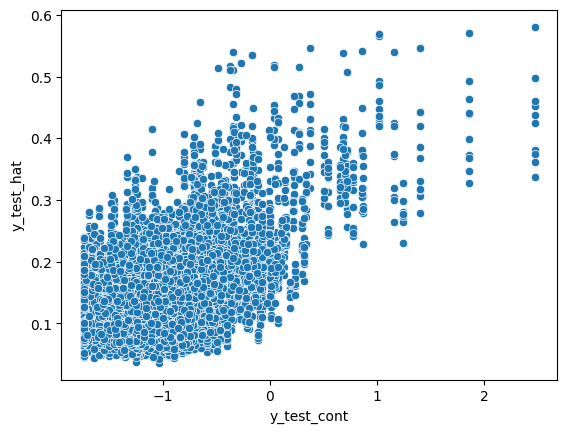

In [ ]:
sns.scatterplot(data=tmp_df,x='y_test_cont',y='y_test_hat')